<a href="https://colab.research.google.com/github/jonesLevin/TensorFlow-Deep-Learning/blob/main/Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning: Fine Tuning

## Creating Helper Functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-31 07:06:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-31 07:06:05 (65.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Importing helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

## Getting the Data
We Try to see if we can use pretrained models in tf.keras.applications

In [3]:
# Get 10% of training data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data('10_food_classes_10_percent.zip')

--2023-01-31 07:06:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.127.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  39.8MB/s    in 5.1s    

2023-01-31 07:06:14 (31.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check how many images and sub dirs are in our file
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [4]:
# Creating training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [10]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Model 0: Transfer Learning Model Using Functional API

In [13]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using ResNet50v2, then we need to normalize the inputs
# x = tf.keras.layers.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f'Shape after passing inputs through the base model: {x.shape}')

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after global pooling 2d layer: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with outputs
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# 10. Fitting the model
model_0_history = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name='10%_feature_extraction')])

Shape after passing inputs through the base model: (None, 7, 7, 1280)
Shape after global pooling 2d layer: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10%_feature_extraction/20230131-074918
Epoch 1/5
24/24 [==============================] - 19s 252ms/step - loss: 1.8646 - accuracy: 0.4387 - val_loss: 1.2895 - val_accuracy: 0.7352
Epoch 2/5
24/24 [==============================] - 4s 146ms/step - loss: 1.0847 - accuracy: 0.7667 - val_loss: 0.8559 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 4s 145ms/step - loss: 0.7840 - accuracy: 0.8187 - val_loss: 0.6824 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 4s 143ms/step - loss: 0.6546 - accuracy: 0.8413 - val_loss: 0.6180 - val_accuracy: 0.8421
Epoch 5/5
24/24 [==============================] - 5s 181ms/step - loss: 0.5510 - accuracy: 0.8720 - val_loss: 0.5750 - val_accuracy: 0.8569


In [14]:
# Evaluate on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.5542 - accuracy: 0.8672


[0.5542223453521729, 0.8672000169754028]

In [ ]:
base_model.summary()

In [18]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


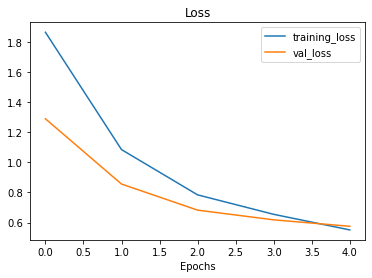

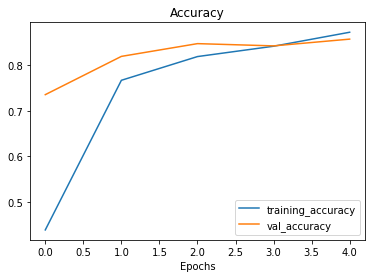

In [19]:
# Check the models training curves
plot_loss_curves(model_0_history)

## Getting a feauter vector from the trained model

In [23]:
from tensorflow import keras

# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [26]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [27]:
global_max_pooled_tensor = keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f'2D global max pooled random tensor:\n {global_max_pooled_tensor}\n')

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]



## Running A Series of Experiments

In [28]:
# Downloading and unzipping data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-01-31 08:22:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  31.7MB/s    in 4.6s    

2023-01-31 08:22:05 (27.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [29]:
unzip_data('10_food_classes_1_percent.zip')

In [31]:
# Create training and test dirs
train_data_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [32]:
# Set up data loaders
train_data_1_percent = keras.preprocessing.image_dataset_from_directory(train_data_1_percent,
                                                                        image_size=IMG_SIZE,
                                                                        label_mode='categorical',
                                                                        batch_size=BATCH_SIZE)
test_data = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             image_size=IMG_SIZE,
                                                             label_mode='categorical')

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation


In [36]:
# Create data augmentation stage
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    keras.layers.experimental.preprocessing.RandomRotation(0.3),
    keras.layers.experimental.preprocessing.RandomZoom(0.2),
    keras.layers.experimental.preprocessing.RandomWidth(0.2),
    keras.layers.experimental.preprocessing.RandomHeight(0.2)
    # keras.layers.preprocessing.Rescale(1./255)
], name='data_augmentation')